## Imports

In [1]:
import numpy as np
import pandas as pd
import swifter
# import pandas_profiling
import pprint
import requests
import pickle

import time
import datetime

from sklearn.cluster import DBSCAN
from sklearn import metrics

import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint, Point, shape
import seaborn as sns; sns.set()

## Jupyter Configurations

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

## Definitions

In [7]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def dbscan_reduce(df, epsilon, min_samples=1, x='lon', y='lat'):
    start_time = time.time()
    
    now = datetime.datetime.now()

    print(f'DBSCAN_Reduce started: {now:%Y-%m-%d %H:%M:%S}')
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
#     coords = df.as_matrix(columns=[y, x]) # Deprecated
    coords = df[[y, x]].values
    
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) #,n_jobs=-1 .... Don't use n_jobs as it makes it take WAY longer

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print(f'Number of clusters found: {num_clusters:,}')
    
    now = datetime.datetime.now()
    print(f'Building clusters started: {now:%Y-%m-%d %H:%M:%S}')
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

    df_c = clusters.to_frame()
    df_c.columns = ['Coords'] # rename column
    
    now = datetime.datetime.now()
    print(f'Cluster centering started: {now:%Y-%m-%d %H:%M:%S}')
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    
    now = datetime.datetime.now()
    print(f'Gathering cluster centers: {now:%Y-%m-%d %H:%M:%S}')
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.swifter.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    print(f'Clustered {len(df):,} points down to {len(rs):,} points, for {100*(1 - float(len(rs)) / len(df)):.2f}% compression in {time.time()-start_time:,.2f} seconds.')
    
    return rs, df_c

# function to return key for any value 
def get_key(func_dict, val): 
    for key, value in func_dict.items(): 
         if val[0] == value[0] and val[1] == value[1]: 
            return key
    
    return -1

## Read Data

In [8]:
%%time

infile = open('US_Accidents_Dec19', 'rb')
df = pickle.load(infile)
infile.close()

print(f'Rows Imported: {len(df):,}')

Rows Imported: 2,974,335
CPU times: user 2.56 s, sys: 1.33 s, total: 3.88 s
Wall time: 3.95 s


# Cluster by GPS coordinates
### https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb
### https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
## Remove rows where the Longitude and/or Latitude are null values

In [9]:
%%time

df.dropna(axis=0,how='any',subset=['Start_Lat','Start_Lng'],inplace=True)

print(f'Rows Remaining: {len(df):,}')

Rows Remaining: 2,974,335
CPU times: user 782 ms, sys: 299 ms, total: 1.08 s
Wall time: 1.21 s


## DBSCAN to find the clusters

In [11]:
%%time 
#37 min, 33 s for DBSCAN of full data set as eps=1km in radians, min_samples=1: 1.3M unclustered and largest cluster is 149945
#xx min, xx s for DBSCAN of full data set as eps=.25km in radians, min_samples=2: xx clusters, xx unclustered, largest cluster is xx

# first cluster the full gps location history data set coarsely
eps_rad = .25 / kms_per_radian
df_clustered, df_clusters = dbscan_reduce(df, epsilon=eps_rad, min_samples=1, x='Start_Lng', y='Start_Lat')

DBSCAN_Reduce started: 2020-03-30 07:32:39
Number of clusters found: 298,342
Building clusters started: 2020-03-30 07:38:43
Cluster centering started: 2020-03-30 08:13:10
Gathering cluster centers: 2020-03-30 08:14:49



Clustered 2,974,335 points down to 298,342 points, for 89.97% compression in 5,865.98 seconds.
CPU times: user 1h 30min 58s, sys: 2min 24s, total: 1h 33min 22s
Wall time: 1h 37min 46s


## Build cluster labels dict and map to create the Cluster label column

In [12]:
%%time

cluster_coords_dict = {}

# Nested loops go brrrr
# Each cluster potentially has multiple rows and each row has multiple gps coord tuples
for cluster, row in df_clusters.iterrows():
    for coord in row:
        for coord_tup in coord:
            cluster_coords_dict[round(coord_tup[0],6), round(coord_tup[1],6)] = cluster

CPU times: user 54.4 s, sys: 381 ms, total: 54.7 s
Wall time: 55.5 s


In [13]:
%%time

df['Cluster'] = df.set_index(['Start_Lat', 'Start_Lng']).index.map(cluster_coords_dict.get).fillna(value=-1).astype(int)


CPU times: user 5.69 s, sys: 1.1 s, total: 6.79 s
Wall time: 6.81 s


In [14]:
df['Cluster'].value_counts()

-1         1312958
 6263        31853
 42436       21247
 42440       21158
 42444       16962
 65922       16312
 66020       13478
 18470       12607
 47370        9618
 11892        7969
 27556        7811
 27558        7772
 65939        7271
 66560        6404
 6276         5746
 66057        5662
 66001        5649
 25196        5425
 22727        5272
 11919        5192
 6288         5092
 325          5014
 6267         4816
 25200        4659
 6320         4639
 330          4435
 34379        4404
 332          4395
 21454        4358
 66041        4271
 66342        4206
 66163        4095
 65991        3942
 3            3827
 66003        3520
 65893        3513
 34383        3501
 66004        3400
 27523        3339
 18500        2991
 25229        2918
 25199        2897
 6283         2733
 383          2723
 6311         2656
 349          2570
 355          2525
 42458        2487
 18469        2475
 42472        2468
 6363         2388
 47384        2357
 22718      

In [15]:
df_unclustered = df.loc[df['Cluster'] == -1]
df_clustered_largest = df.loc[df['Cluster'] == 6263]

In [16]:
df_clustered_largest['State'].value_counts()
df_clustered_largest.head(100)

CA    31853
Name: State, dtype: int64

ID    TMC  Severity          Start_Time            End_Time  \
42865  A-42866  343.0         2 2016-06-21 10:44:12 2016-06-21 11:22:00   
42867  A-42868  201.0         3 2016-06-21 10:49:21 2016-06-21 11:34:21   
42881  A-42882  201.0         3 2016-06-21 10:51:45 2016-06-21 11:36:45   
42914  A-42915  229.0         3 2016-06-21 12:00:06 2016-06-21 12:42:00   
42924  A-42925  201.0         3 2016-06-21 12:18:26 2016-06-21 13:01:00   
42925  A-42926  201.0         2 2016-06-21 12:20:43 2016-06-21 13:04:00   
42940  A-42941  203.0         2 2016-06-21 13:12:38 2016-06-21 13:57:38   
42941  A-42942  201.0         2 2016-06-21 13:07:43 2016-06-21 13:52:43   
42946  A-42947  201.0         2 2016-06-21 13:18:58 2016-06-21 14:03:58   
42955  A-42956  201.0         2 2016-06-21 13:41:58 2016-06-21 14:26:58   
42963  A-42964  201.0         2 2016-06-21 13:56:35 2016-06-21 14:41:35   
42971  A-42972  201.0         2 2016-06-21 14:21:46 2016-06-21 15:06:46   
42986  A-42987  201.0         2 2016-06-21 15:14:34 2016-06-21 15:59:34   
42987  A-42988  201.0         2 2016-06-21 15:20:54 2016-06-21 16:05:54   
42993  A-42994  201.0         2 2016-06-21 15:36:24 2016-06-21 16:21:24   
43011  A-43012  201.0         2 2016-06-21 16:01:15 2016-06-21 16:46:15   
43018  A-43019  201.0         2 2016-06-21 16:22:03 2016-06-21 17:07:03   
43026  A-43027  241.0         2 2016-06-21 17:04:32 2016-06-21 17:49:32   
43029  A-43030  201.0         2 2016-06-21 17:11:56 2016-06-21 17:56:56   
43040  A-43041  201.0         2 2016-06-21 17:37:22 2016-06-21 18:22:22   
43068  A-43069  201.0         3 2016-06-21 18:30:29 2016-06-21 19:15:29   
43075  A-43076  201.0         2 2016-06-21 18:43:43 2016-06-21 19:28:43   
43095  A-43096  201.0         3 2016-06-21 19:43:41 2016-06-21 20:28:41   
43103  A-43104  201.0         3 2016-06-21 19:57:52 2016-06-21 20:42:52   
43110  A-43111  201.0         2 2016-06-21 20:06:48 2016-06-21 20:51:48   
43124  A-43125  201.0         2 2016-06-21 20:40:26 2016-06-21 21:25:26   
43140  A-43141  201.0         3 2016-06-21 20:55:55 2016-06-21 21:40:55   
43142  A-43143  201.0         2 2016-06-21 20:56:20 2016-06-21 21:41:20   
43147  A-43148  201.0         3 2016-06-21 21:06:23 2016-06-21 21:51:23   
43153  A-43154  241.0         3 2016-06-21 21:23:44 2016-06-21 22:08:44   
43161  A-43162  201.0         3 2016-06-21 22:21:12 2016-06-21 22:51:12   
43169  A-43170  201.0         2 2016-06-22 00:10:37 2016-06-22 00:55:37   
43175  A-43176  241.0         3 2016-06-22 01:34:39 2016-06-22 02:34:39   
43180  A-43181  201.0         3 2016-06-22 02:06:16 2016-06-22 03:06:16   
43183  A-43184  241.0         3 2016-06-22 02:04:59 2016-06-22 03:04:59   
43194  A-43195  201.0         2 2016-06-22 06:10:45 2016-06-22 07:02:00   
43195  A-43196  201.0         2 2016-06-22 06:09:16 2016-06-22 06:51:00   
43197  A-43198  201.0         2 2016-06-22 07:01:11 2016-06-22 07:41:00   
43203  A-43204  241.0         2 2016-06-22 08:54:23 2016-06-22 09:36:00   
43206  A-43207  201.0         2 2016-06-22 08:36:20 2016-06-22 09:18:00   
43213  A-43214  201.0         3 2016-06-22 09:28:25 2016-06-22 10:12:00   
43219  A-43220  201.0         3 2016-06-22 10:00:55 2016-06-22 10:42:00   
43243  A-43244  241.0         2 2016-06-22 11:01:42 2016-06-22 11:46:42   
43244  A-43245  241.0         2 2016-06-22 11:01:22 2016-06-22 11:42:00   
43269  A-43270  241.0         3 2016-06-22 11:42:26 2016-06-22 12:23:00   
43287  A-43288  201.0         2 2016-06-22 12:15:23 2016-06-22 13:00:23   
43293  A-43294  201.0         3 2016-06-22 12:41:57 2016-06-22 13:24:00   
43296  A-43297  201.0         3 2016-06-22 12:58:39 2016-06-22 13:39:00   
43306  A-43307  201.0         3 2016-06-22 13:29:41 2016-06-22 14:14:41   
43362  A-43363  201.0         3 2016-06-22 17:00:45 2016-06-22 18:00:45   
43368  A-43369  201.0         2 2016-06-22 17:05:02 2016-06-22 18:05:02   
43373  A-43374  201.0         3 2016-06-22 17:15:58 2016-06-22 18:15:58   
43374  A-43375  201.0         2 2016-

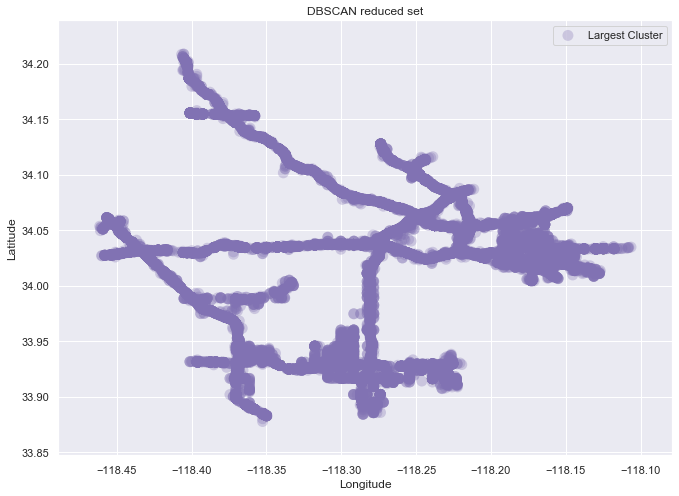

CPU times: user 907 ms, sys: 53.3 ms, total: 960 ms
Wall time: 1e+03 ms


In [17]:
%%time

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered_largest['Start_Lng'], df_clustered_largest['Start_Lat'], c='m', edgecolor='None', alpha=0.3, s=120)
# df_scatter = ax.scatter(df['Start_Lng'], df['Start_Lat'], c='k', alpha=0.5, s=3)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([rs_scatter], ['Largest Cluster'], loc='upper right')
plt.show()

In [ ]:
%%time

# next, sample every nth row (where n=sample_rate) of the full gps location history data set
# sample_rate = 20
# df_sampled = df.iloc[range(0, len(df), sample_rate)]

# sample a percentage of the full gps location data set
df_sampled = df.sample(frac = 0.05, replace = False, random_state = 42)
len(df_sampled)

df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.1 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad, x='Start_Lng', y='Start_Lat')

In [ ]:
%%time

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['Start_Lng'], df_final['Start_Lat'], c='m', edgecolor='None', alpha=0.3, s=120)
# df_scatter = ax.scatter(df['Start_Lng'], df['Start_Lat'], c='k', alpha=0.5, s=3)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([rs_scatter], ['Reduced set'], loc='upper right')
plt.show()

In [ ]:
%%time

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['Start_Lng'], df_final['Start_Lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df['Start_Lng'], df['Start_Lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [ ]:
# Within the clusters, count incidents by each day to see if there are any secondary collisions that occur during the initial incident timeframe